In [16]:
"""
This script is suposed to produce plots of the results from
macroscopic approximation of the network-based microscopic model of divestment.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class plot_routines(object):
    """
    this contains the routines to make different plots to compare the two
    types of model description
    """

    def __init__(self, base_path_micro, base_path_macro):
        approx = ['micro', 'mean']
        estimator = ['mean', 'std']
        self.data_sets = []
        for a, path in zip(approx, (base_path_micro, base_path_macro)):
            for e in estimator:
                with pd.HDFStore(path + '{}/{}.h5'.format(a, e)) as store:
                    self.data_sets.append(store.select('dat'))

        for d in self.data_sets:
            d.index = d.index.droplevel('sample').droplevel('test').droplevel('approximate')

        self.variable_combos = [['x', 'y', 'z'], ['c', 'g'], ['mu_c^c', 'mu_d^d'],
                                ['mu_c^d', 'mu_d^c']]
        #self.variable_combos = [['x', 'y', 'z'], ['c', 'g'], ['r_c', 'r_d'],
        #                ['W_c', 'W_d']]
        self.latex_labels = [['$x$', '$y$', '$z$'], ['$c$', '$g$'],
                             ['$\mu^{(c)}_c$', '$\mu^{(d)}_d$'],
                             ['$\mu^{(c)}_d$', '$\mu^{(d)}_c$']]
        #self.latex_labels = [['$x$', '$y$', '$z$'], ['$c$', '$g$'],
        #             ['$r_c$', '$r_d$'],
        #             ['$W_c$', '$W_d$']]

        self.colors = 'rgbk'

    def mk_plots(self, bd):

        # select data for given value of bd
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs(bd, level=0))

        phi_vals = local_datasets[0].index.levels[0].values

        l_phi = len(phi_vals)
        l_vars = len(self.variable_combos)

        fig = plt.figure()
        axes = [fig.add_subplot(l_vars, l_phi, i + 1 + j * l_phi)
                for i in range(l_phi)
                for j in range(l_vars)]

        for i, phi in enumerate(phi_vals):
            for j, variables in enumerate(self.variable_combos):
                ax_id = self.grid_index(i, j, l_phi, l_vars) - 1
                # local data set for specifiv value of phi
                ldp = []
                for d in local_datasets:
                    ldp.append(d.xs(phi, level=0))
                print(self.grid_index(i, j, l_phi, l_vars))
                ldp[0][variables]\
                    .plot(
                    ax=axes[ax_id],
                    legend=False,
                    color=self.colors)
                for k, variable in enumerate(variables):
                    upper_limit = np.transpose(ldp[0][[variable]].values \
                                  + ldp[1][[variable]].values)[0]
                    lower_limit = np.transpose(ldp[0][[variable]].values \
                                  - ldp[1][[variable]].values)[0]
                    axes[ax_id].fill_between(ldp[0].index.values,
                                     upper_limit, lower_limit,
                                     color=self.colors[k],
                                     alpha=0.2)
                    ldp[2][variables] \
                        .plot(
                        ax=axes[ax_id],
                        legend=False,
                        color=self.colors,
                        style='-.')

        return fig

    def mk_switchplots(self, bd, phi):
                # select data for given value of bd and phi
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs([bd, phi], level=[0, 1]))
        switchlist = np.load('switch_bd={}_phi={}.pkl'.format(bd, phi))

        fig = plt.figure()

        vars = self.variable_combos[2] + self.variable_combos[3]
        for v, var in enumerate(vars):
            direction = 1 if var[-2] == 'c' else 0
            capital_kind = '$K^{(c)}$' if var[-1] == 'c' else '$K^{(d)}$'
            print( var, capital_kind, direction)
            c1 = 'b'
            ax1 = fig.add_subplot(2, 2, v + 1)
            mu = local_datasets[0][[var]]
            emu = local_datasets[1][[var]]
            upper = np.transpose(np.array(mu.values + 2*emu.values))[0]
            lower = np.transpose(np.array(mu.values - 2*emu.values))[0]
            mu.plot(ax=ax1)
            ax1.plot(emu.index.values, upper, color=c1, alpha=0.4)
            ax1.plot(emu.index.values, lower, color=c1, alpha=0.4)
            plt.fill_between(emu.index.values,
                             upper,
                             lower,
                             color='k', alpha=0.2)
            l = len(switchlist[['direction']].values)
            ldots = 1000
            ts = []
            ks = []
            for i in range(ldots):
                k = np.random.randint(l)
                t = 1 if switchlist[['direction']].values[k] == direction else 0
                if t:
                    ts.append(switchlist.index.values[k])
                    ks.append(switchlist[[capital_kind]].values[k])
            ax1.plot(ts, ks, 'o'+c1, alpha=0.2, label=capital_kind)
            handles, labels = ax1.get_legend_handles_labels()
            ax1.legend(handles, ['$\mu_{}^{{({})}}$'.format(var[-2], var[-1]), capital_kind], loc=0)
        return fig



    def mk_4plots(self, bd, phi, eps):
        # set opacity for plots of micro data:
        micro_alpha=0.8
        # select data for given value of bd and phi
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs([bd, phi, eps], level=[0, 1, 2]))

        l_vars = len(self.variable_combos)
        fig = plt.figure(figsize=(8,6))
        axes = [fig.add_subplot(2, 2, i + 1) for i in range(l_vars)]

        legend_locations = [4, 7, 1, 7]
        upper_limits = [0.8, 40, 11, 6]
        lower_limits = [-.6, 0., 0., 0.]

        for j, variables in enumerate(self.variable_combos):
            ax_id = j
            #axes[ax_id].set_xlim([0,100])
            # local data set for specify value of phi
            ldp = local_datasets
            if j == 1:
                print( 'c exception')
                c_ax = axes[ax_id].twinx()
                ldp[0][variables[0]] \
                    .plot(
                    ax=axes[ax_id],
                    color=self.colors[0],
                    alpha=micro_alpha)
                ldp[0][variables[1]] \
                    .plot(
                    ax=c_ax,
                    color=self.colors[1],
                    alpha=micro_alpha)

                c_ax.set_ylim([0, 5])
            else:
                ldp[0][variables] \
                    .plot(
                    ax=axes[ax_id],
                    color=self.colors,
                    alpha=micro_alpha)
            for k, variable in enumerate(variables):
                ax = axes[ax_id]
                if variable == 'g':
                    ax = c_ax

                upper_limit = np.transpose(ldp[0][[variable]].values \
                                           + ldp[1][[variable]].values)[0]
                lower_limit = np.transpose(ldp[0][[variable]].values \
                                           - ldp[1][[variable]].values)[0]
                ax.fill_between(ldp[0].index.values,
                                         upper_limit, lower_limit,
                                         color='k',
                                         alpha=0.05)
                ax.plot(ldp[0].index.values,
                                         upper_limit,
                                         color=self.colors[k],
                                         alpha=0.2)
                ax.plot(ldp[0].index.values,
                                         lower_limit,
                                         color=self.colors[k],
                                         alpha=0.2)
                
                ldp[2][[variable]] \
                    .plot(ax=ax,
                          color=self.colors[k],
                          legend=False,
                          style='--',
                          linewidth=2
                          )

            ax = axes[ax_id]
            #ax.set_ylim([lower_limits[j], upper_limits[j]])
            k = len(variables)
            patches, labels = ax.get_legend_handles_labels()
            labels = self.latex_labels[j]
            if j == 1:
                gArtist = plt.Line2D((0,1),(0,0), color=self.colors[1])
                cArtist = plt.Line2D((0,1),(0,0), color=self.colors[0])
                patches = [cArtist, gArtist]
            if j is 0:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            lg = ax.legend(patches[:k], labels[:k],
                           loc=legend_locations[ax_id],
                           title='',
                           fontsize=12)
            lg.get_frame().set_alpha(0.8)

            #ax.set_title('')
            #ax.set_loc

        return fig


    def grid_index(self, row, col, n_rows, n_cols):
        """
        calculate index number in subplot grids
        grid_index(0,0) = 1 ~ upper left corner
        to index the axis list, one might use grid_index - 1
        """
        return col + 1 + row * n_cols

c exception


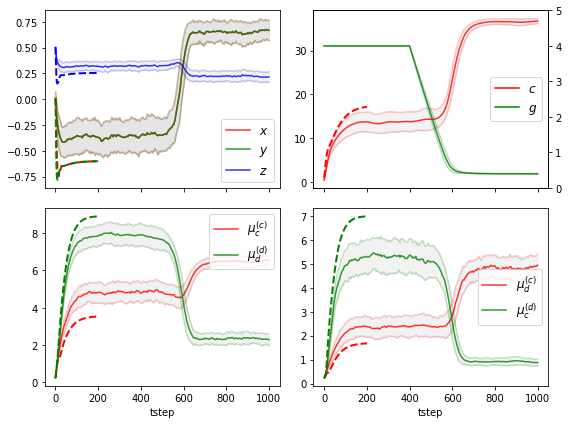

In [19]:
import time

bc, eps = 1.25, 0.05

test_path = '/home/jakob/Project_Divestment/PyDivestment/output_data/test_output/P2/'
production_path = '/home/jakob/Project_Divestment/PyDivestment/output_data/P2/'

prt = plot_routines(base_path_macro=test_path, base_path_micro=production_path)


#for phi in [round(x, 5) for x in list(np.linspace(0.0, 0.9, 10))]:
for phi in [.4]:

    figure = prt.mk_4plots(bc, phi, eps)
    figure.tight_layout()
    figure.savefig('trajectory_bc={}_phi={}.pdf'.format(bc, phi))
